In [15]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from time import time
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras.callbacks import History 
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

In [25]:
#Read the training file and record the running time
time_1 = time()
data = pd.read_csv('/Users/Andy/Desktop/depth_okex_btc_usd_quarter.csv', sep = ',', parse_dates=[0], dayfirst = True)
time_2 = time()
print('read data cost '+ str(time_2 - time_1)+' second')

read data cost 0.01523900032043457 second


In [38]:
data_1 = data.values.tolist()
Bidprice_first = []
for i in range(len(data_1)):
    first = data_1[i][0].split(';')
    Bidprice_first.append(first[0])
print(len(Bidprice_first))
print(Bidprice_first)

101
['6229.46', '6229.46', '6229.46', '6229.46', '6229.46', '6229.46', '6229.46', '6229.46', '6229.46', '6229.46', '6229.46', '6229.46', '6229.46', '6230.09', '6230.09', '6230.09', '6231', '6230.22', '6230.22', '6230.22', '6230.22', '6230.22', '6230.22', '6230.22', '6230.22', '6230.22', '6230.22', '6230.22', '6230.22', '6230.5', '6230.5', '6230.99', '6230.99', '6230.99', '6230.99', '6230.99', '6230.99', '6230.99', '6230.99', '6231.01', '6231.01', '6231.01', '6231.01', '6231.01', '6231.01', '6231.01', '6231.01', '6231.01', '6231', '6231', '6231', '6231.01', '6231.01', '6231.01', '6231.01', '6231', '6231', '6231', '6231', '6231', '6231.01', '6231.01', '6231.01', '6231.01', '6231.01', '6231.01', '6231.01', '6231.01', '6231.01', '6232.45', '6232.53', '6231.01', '6231.5', '6231.5', '6232.02', '6232.02', '6232.02', '6232.02', '6232.02', '6232.02', '6232.02', '6232.02', '6232.02', '6232.02', '6232.02', '6232.02', '6232.02', '6232.02', '6232.02', '6232.02', '6232.02', '6232.02', '6232.02', '62

In [34]:
print(len(data_1))

101


In [2]:
#Read the training file and record the running time
time_1 = time()
data = pd.read_csv('/Users/Andy/Desktop/DataScience/Capstone/Data/bitcoin_train.csv', sep = ',', parse_dates=[0], dayfirst = True)
time_2 = time()
print('read data cost '+ str(time_2 - time_1)+' second')

read data cost 0.1770470142364502 second


In [3]:
col_n = ['date','close']
data_select = pd.DataFrame(data,columns = col_n)
data_select.isnull().values.any()
# data for image
data_image = data_select.dropna() # Drop all Nans
data_image = data_select.values
# date
data_select['date'] = pd.to_datetime(data_select['date'])
data_select.sort_values('date', inplace = True)

In [4]:
data_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546 entries, 545 to 0
Data columns (total 2 columns):
date     546 non-null datetime64[ns]
close    546 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.8 KB


## The describe() function in pandas is very handy in getting various summary statistics.This function returns the count, mean, standard deviation, minimum and maximum values and the quantiles of the data.

In [5]:
data_select.describe()

,close
count,546.000000
mean,5714.509029
std,4321.857100
min,777.760000
25%,1858.590000
50%,4572.035000
75%,8435.865000
max,19497.400000


## Visulation for Bitcoin Price

Text(0, 0.5, 'close price')

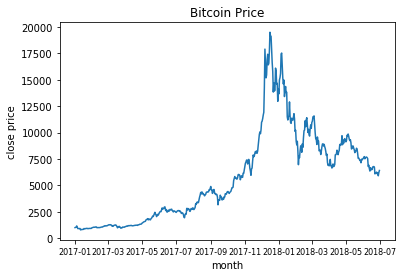

In [6]:
x_month = data_image[:,1]
y_number = data_image[:,0]
plt.figure() 
plt.plot(y_number, x_month) 
plt.title('Bitcoin Price') 
plt.xlabel('month') 
plt.xticks(fontsize=8)
plt.ylabel('close price')

## We perform a seasonal decomposition of the data to estimate its trend and seasonality. You can see the actual price movements on the plot below (“observed”) as well as the trend and seasonality in our data. 

Additive model:

Data is represented in terms of addition of seasonality, trend, cyclical and residual components

Used where change is measured in absolute quantity

Data is modeled as-is

Multiplicative model:

Data is represented in terms of multiplication of seasonality, trend, cyclical and residual components

Used where change is measured in percent(%) change

Data is modeled just as additive but after taking logarithm (with base as natural or base 10)

The additive model is useful when the seasonal variation is relatively constant over time. The multiplicative model is useful when the seasonal variation increases over time.

In [7]:
s = sm.tsa.seasonal_decompose(data_select.close.values, freq=60)
trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(238, 0, 0)'), width = 4))

trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(0, 255, 0)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(255, 255, 0)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')

## The next thing we do is the examination of the autocorrelation. It is it is the similarity between observations as a function of the time lag between them. It is important for finding repeating patterns in the data. 

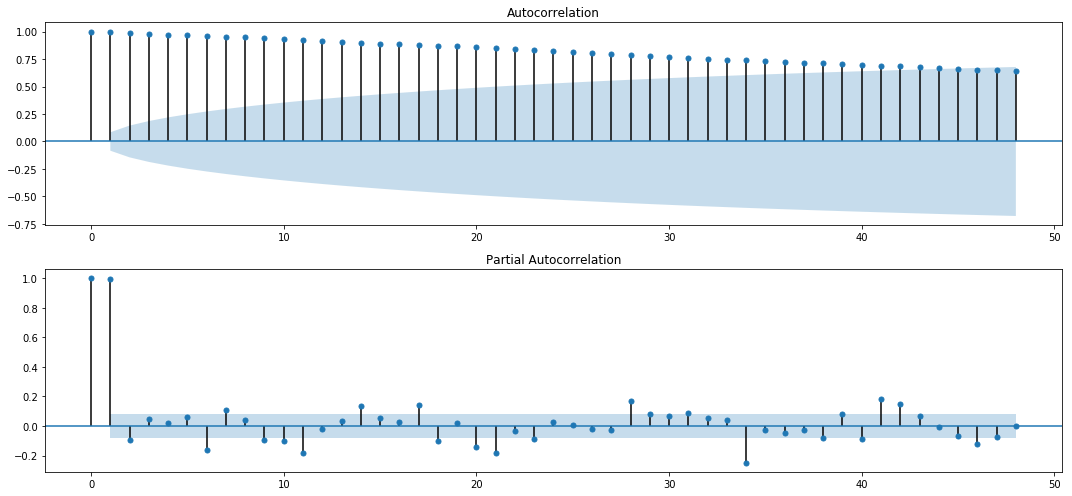

In [8]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_select.close.values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_select.close.values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [9]:
training_data = data_select[:-46]
testing_data = data_select[-46:]

We need to prepare our dataset according to the requirements of the model, as well as to split the dataset into train and test parts. In the next cell, we define a function which creates X inputs and Y labels for our model. In the sequential forecasting, we predict the future value based on some previous and current values. So, our Y label is the value from the next (future) point of time while the X inputs are one or several values from the past. The amount of these values we can set by tuning the parameter look_back in our function. If we set it to 1, this means that we predict current value t based on the previous value (t-1).

In [10]:
def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

Now we perform final data preparation:
1. Scale the dataset by using the MinMaxScaler because LSTM models are scale sensitive.
2. Apply create_lookback function

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#Reshape and scale datasets
training_set = training_data.values
price_set_1 = training_set[:,1]
date_values_1 = training_set[:,0]
training_set = np.reshape(price_set_1, (len(price_set_1), 1))
date_set_1 = np.reshape(date_values_1, (len(date_values_1), 1))
train_set = scaler.fit_transform(training_set)
df_train = np.concatenate((date_set_1, train_set), axis = 1)

testing_set = testing_data.values
price_set_2 = testing_set[:,1]
date_values_2 = testing_set[:,0]
testing_set = np.reshape(price_set_2, (len(price_set_2), 1))
date_set_2 = np.reshape(date_values_2, (len(date_values_2), 1))
test_set = scaler.fit_transform(testing_set)
df_test = np.concatenate((date_set_2, test_set), axis = 1)

train_set_1 = pd.DataFrame(train_set)     
test_set_1 = pd.DataFrame(test_set)
working_data = [train_set_1, test_set_1]
working_data = pd.concat(working_data)

# create datasets which are suitable for time series forecasting
look_back = 1
X_train, Y_train = create_lookback(train_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

# reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
X_train = np.reshape(X_train, (len(X_train), X_train.shape[1], 1))
X_test = np.reshape(X_test, (len(X_test), X_test.shape[1], 1))

/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning:

Data with input dtype object was converted to float64 by MinMaxScaler.

/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning:

Data with input dtype object was converted to float64 by MinMaxScaler.



In [13]:
print(X_train.shape)

(499, 1, 1)


In [161]:
# initialize sequential model, add 2 stacked LSTM layers and densely connected output neuron
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=len(train_x[0])))
model.add(LSTM(256))
model.add(Dense(1))
time_3 = time()
print(model.summary())
# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')

# callbacks
# monitor: quantity to be monitor; min_delta: minimum change in the monitored quantity to qualify as an improvement, 
#i.e. an absolute change of less than min_delta, will count as no improvement.
#patience: number of epochs with no improvement after which training will be stopped.
#verbose: verbosity mode.
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
                    validation_data=(X_test, Y_test),
                   callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])
#history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
#                    validation_data=(X_test, Y_test),
#                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])
time_4 = time()
print('Traing cost '+ str(time_4 - time_3)+' second')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 1, 256)            264192    
_________________________________________________________________
lstm_79 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 257       
Total params: 789,761
Trainable params: 789,761
Non-trainable params: 0
_________________________________________________________________
None
Train on 499 samples, validate on 45 samples
Epoch 1/100
499/499 [==============================] - 38s 76ms/step - loss: 0.0360 - val_loss: 0.0372
Epoch 2/100
499/499 [==============================] - 2s 4ms/step - loss: 0.0583 - val_loss: 0.0211
Epoch 3/100
499/499 [==============================] - 2s 5ms/step - loss: 0.0176 - val_loss: 0.0105
Epoch 4/100
499/499 [========================

In [136]:
trace1 = go.Scatter(
    x = np.arange(0, len(history.history['loss']), 1),
    y = history.history['loss'],
    mode = 'lines',
    name = 'Train loss',
    line = dict(color=('rgb(66, 244, 155)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_loss']), 1),
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Test loss',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Train and Test Loss during training',
              xaxis = dict(title = 'Epoch number'), yaxis = dict(title = 'Loss'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='training_process')

In [17]:
# get predictions and then make some transformations to be able to calculate RMSE properly in USD
prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

In [18]:
trace1 = go.Scatter(
    x = np.arange(0, len(prediction2_inverse), 1),
    y = prediction2_inverse,
    mode = 'lines',
    name = 'Predicted labels',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(Y_test2_inverse), 1),
    y = Y_test2_inverse,
    mode = 'lines',
    name = 'True labels',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

In [19]:
RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 238.800


In [148]:
def build_LSTM_model(X_train, Y_train, X_test, Y_test, n_layers, n_neurons, activ_func, dropout_rate, loss, optimizer):
    """
    X_train, Y_train, X_test, Y_test: the data for training and testing
    neurons: number of neurons/units in the layer
    active_func: Activation function to be used in LSTM layers and Dense layer
    dropout: dropout ration
    loss: loss function for calculating the gradient
    optimizer: type of optimizer to backpropagate the gradient
    These models will build 1-3 layered RNN model with LSTM cells with dropouts after each LSTM layer.
    Return: Keras sequential model and model summary
    """
    model = Sequential()
    for i in range(0,n_layers):
        if i == 0:
            if n_layers == 1:
                model.add(LSTM(n_neurons, input_shape=(len(X_train[0]))))
            elif n_layers > 1:
                model.add(LSTM(n_neurons, return_sequences = True, input_shape=(len(X_train[0]))))
        elif i > 0:
            if i < n_layers - 1:
                model.add(LSTM(n_neurons, return_sequences = True))
            elif i == n_layers -1:
                model.add(LSTM(n_neurons))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.summary()
    # compile and fit the model
    model.compile(loss = loss, optimizer = optimizer)
    model.summary()
    history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
                    validation_data=(X_test, Y_test),
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])
    return history

In [137]:
def build_GRU_model(X_train, Y_train, X_test, Y_test, n_layers, n_neurons, activ_func, dropout_rate, loss, optimizer):
    """
    X_train, Y_train, X_test, Y_test: the data for training and testing
    neurons: number of neurons/units in the layer
    active_func: Activation function to be used in LSTM layers and Dense layer
    dropout: dropout ration
    loss: loss function for calculating the gradient
    optimizer: type of optimizer to backpropagate the gradient
    These models will build 1-3 layered RNN model with LSTM cells with dropouts after each LSTM layer.
    Return: Keras sequential model and model summary
    """
    model = Sequential()
    for i in range(0,n_layers):
        if i == 0:
            if n_layers == 1:
                model.add(GRU(n_neurons, input_shape=(len(X_train[0]))))
            elif n_layers > 1:
                model.add(GRU(n_neurons, return_sequences = True, input_shape=(len(X_train[0]))))
        elif i > 0:
            if i < n_layers - 1:
                model.add(GRU(n_neurons, return_sequences = True))
            elif i == n_layers -1:
                model.add(GRU(n_neurons))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.summary()
    # compile and fit the model
    model.compile(loss = loss, optimizer = optimizer)
    model.summary()
    history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
                    validation_data=(X_test, Y_test),
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])
    return history

In [122]:
def predict(model):
  global X_test, Y_test
  X_test = np.reshape(X_test, (len(X_test), 1, 1))
  # get predictions and then make some transformations to be able to calculate RMSE properly in USD
  prediction = model.predict(X_test) 
  prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1)) 
  Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1)) 
  prediction2_inverse = np.array(prediction_inverse[:,0][:]) 
  Y_test2_inverse = np.array(Y_test_inverse[:,0]) 
  RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
  #print('Test RMSE: %.3f' % RMSE)
  return RMSE

In [125]:
def plot_loss(criteria, title, label):

  size = len(loss[0])
  colors = ['blue','red','green','orange','grey']
  data = []
  for i in range(0,len(loss)):
    trace = go.Scatter(
        x = np.arange(0, size, 1),
        y = loss[i],
        mode = 'lines',
        name = label + ' = ' + str(criteria[i]),
        line = dict(color=colors[i], width=2)
    )
    data.append(trace)
  layout = dict(title = 'Test Loss of different ' + title,
                xaxis = dict(title = 'Epoch number'), yaxis = dict(title = 'Loss'))
  fig = dict(data=data, layout=layout)
  py.iplot(fig, filename='training_process')

In [149]:
# Adam
learning_rate = [0.00001,0.0001,0.001,0.01,0.1]
loss = []
for lr in learning_rate:
  optimizer = Adam(lr=lr, decay=1e-6)
  h = build_LSTM_model(X_train, Y_train, X_test, Y_test, 2, 256, 'tanh', 0, 'mean_squared_error', optimizer)
  loss.append(h.history['val_loss'])
  
#configure_plotly_browser_state()
plot_loss(learning_rate, 'Adam learnig rates', 'lr')
print('Best learning rate:', str(learning_rate[np.argmin([loss[0][-1],loss[1][-1],loss[2][-1],loss[3][-1],loss[4][-1]])]))
print('Best loss:', str(np.min([loss[0][-1],loss[1][-1],loss[2][-1],loss[3][-1],loss[4][-1]])))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 1, 256)            264192    
_________________________________________________________________
lstm_69 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 257       
Total params: 789,761
Trainable params: 789,761
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 1, 256)            264192    
_________________________________________________________________
lstm_69 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dens

499/499 [==============================] - 2s 4ms/step - loss: 0.0011 - val_loss: 0.0075
Epoch 32/100
499/499 [==============================] - 2s 3ms/step - loss: 0.0010 - val_loss: 0.0076
Epoch 33/100
499/499 [==============================] - 2s 3ms/step - loss: 9.0535e-04 - val_loss: 0.0077
Epoch 34/100
499/499 [==============================] - 1s 3ms/step - loss: 8.4042e-04 - val_loss: 0.0078
Epoch 35/100
499/499 [==============================] - 1s 3ms/step - loss: 7.9712e-04 - val_loss: 0.0079
Epoch 36/100
499/499 [==============================] - 1s 3ms/step - loss: 7.6875e-04 - val_loss: 0.0080
Epoch 37/100
499/499 [==============================] - 1s 3ms/step - loss: 7.5042e-04 - val_loss: 0.0081
Epoch 38/100
499/499 [==============================] - 2s 3ms/step - loss: 7.3867e-04 - val_loss: 0.0082
Epoch 39/100
499/499 [==============================] - 1s 3ms/step - loss: 7.3113e-04 - val_loss: 0.0082
Epoch 40/100
499/499 [==============================] - 1s 3ms/step

Best learning rate: 0.0001
Best loss: 0.008315398161196046


In [ ]:
# RMSprop 
#[1046.90699647584, 328.6150799042895, 227.3251100927995, 252.9473386128843, 259.9733161862902]
loss = []
for lr in learning_rate:
  optimizer = RMSprop(lr=lr, decay=1e-6)
  history = train_model(X_train, Y_train, X_test, Y_test, optimizer, 128, 1, 16, 0)
  loss.append(history.history['val_loss'])

configure_plotly_browser_state()
plot_loss(learning_rate, 'RMSprop learnig rates', 'lr')
print('Best learning rate:', str(learning_rate[np.argmin([loss[0][-1],loss[1][-1],loss[2][-1],loss[3][-1],loss[4][-1]])]))
print('Best loss:', str(np.min([loss[0][-1],loss[1][-1],loss[2][-1],loss[3][-1],loss[4][-1]])))

In [ ]:
# SGD
# [1098.0822372525574, 846.0444633275769, 382.90657030517235, 232.171269787306, 226.463277492128]
loss = []
for lr in learning_rate:
  optimizer = SGD(lr=lr, momentum=0.9, decay=1e-6, nesterov=True)
  history = train_model(X_train, Y_train, X_test, Y_test, optimizer, 128, 1, 16, 0)
  loss.append(history.history['val_loss'])

configure_plotly_browser_state()
plot_loss(learning_rate, 'SGD learnig rates', 'lr')
print('Best learning rate:', str(learning_rate[np.argmin([loss[0][-1],loss[1][-1],loss[2][-1],loss[3][-1],loss[4][-1]])]))
print('Best loss:', str(np.min([loss[0][-1],loss[1][-1],loss[2][-1],loss[3][-1],loss[4][-1]])))